In [38]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample
import math

# my helpers!
from shared import (
    dataset_local_path,
    bootstrap_auc,
    simple_boxplot,
)

# stdlib:
from dataclasses import dataclass, field
import json, gzip
from typing import Dict, List

In [2]:

#%% load up the data
# Try 'POETRY'
dataset = "WIKI"
examples: List[str] = []
ys: List[bool] = []

if dataset == "WIKI":
    with gzip.open(dataset_local_path("lit-wiki-2020.jsonl.gz"), "rt") as fp:
        for line in fp:
            info = json.loads(line)
            # Note: the data contains a whole bunch of extra stuff; we just want numeric features for now.
            keep = info["body"]
            # whether or not it's poetry is our label.
            ys.append(info["truth_value"])
            # hold onto this single dictionary.
            examples.append(keep)
else:
    # take only one per book!
    by_book = {}
    with open(dataset_local_path("poetry_id.jsonl")) as fp:
        for line in fp:
            info = json.loads(line)
            # dictionary keeps this key unique:
            by_book[info["book"]] = info
    # now extract only one page per book here:
    for info in by_book.values():
        # Note: the data contains a whole bunch of extra stuff; we just want numeric features for now.
        keep = info["words"]
        # whether or not it's poetry is our label.
        ys.append(info["poetry"])
        # hold onto this single dictionary.
        examples.append(keep)

In [39]:
#%% Split data:

RANDOM_SEED = 1234

## split off train/validate (tv) pieces.
ex_tv, ex_test, y_tv, y_test = train_test_split(
    examples,
    ys,
    train_size=0.75,
    shuffle=True,
    random_state=RANDOM_SEED,
)
# split off train, validate from (tv) pieces.
ex_train, ex_vali, y_train, y_vali = train_test_split(
    ex_tv, y_tv, train_size=0.66, shuffle=True, random_state=RANDOM_SEED
)

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

In [37]:
word_features = CountVectorizer(
    strip_accents = 'unicode',
    lowercase = True,
    ngram_range = (1,1))

text_to_words = word_features.build_analyzer()

word_features.fit(ex_train)
X_train = word_features.transform(ex_train)
X_vali = word_features.transform(ex_vali)
X_test = word_features.transform(ex_test)

print(X_train.shape, X_vali.shape, X_test.shape)

#%% Accumulate results here; to be box-plotted.
results: Dict[str, List[float]] = {}

(942, 33176) (486, 33176) (476, 33176)


In [44]:
#%% try sklearn MultinomialNB:

## SKLearn has it's own Multinomial Naive Bayes,
#  and it uses the alpha / additive smoothing to deal with zeros!
from sklearn.naive_bayes import MultinomialNB

# Try a couple alpha values (what to do with zero-prob words!)
# Alpha can really be anything positive!
for alpha in [0.1, 1.0, 10.0]:
    m = MultinomialNB(alpha=alpha)
    m.fit(X_train, y_train)
    scores = m.predict_proba(X_vali)[:, 1]
    print(
        "Accuracy: {:.3}, AUC: {:.3}".format(
            m.score(X_vali, y_vali), roc_auc_score(y_score=scores, y_true=y_vali)
        )
    )
    print("What I called log(beta)={}".format(m.class_log_prior_[1]))
    results["MNB(alpha={})".format(alpha)] = bootstrap_auc(m, X_vali, y_vali)

In [47]:
m.class_log_prior_

array([-0.40228546, -1.10500209])

Accuracy: 0.821, AUC: 0.821
What I called log(beta)=-1.1050020867668806
Accuracy: 0.837, AUC: 0.821
What I called log(beta)=-1.1050020867668806
Accuracy: 0.712, AUC: 0.638
What I called log(beta)=-1.1050020867668806
positive-size: 109601
rand-size: 366515
Linear[0.1] AUC=0.829
Linear[0.2] AUC=0.831
Linear[0.3] AUC=0.832
Linear[0.4] AUC=0.825
Linear[0.5] AUC=0.821
Linear[0.9] AUC=0.784


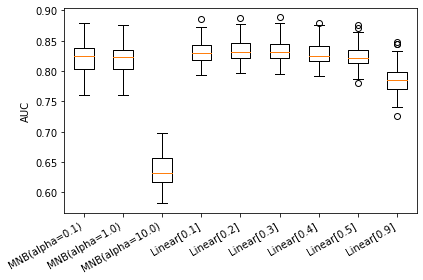

<module 'matplotlib.pyplot' from 'c:\\users\\cliff\\appdata\\local\\programs\\python\\python38\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [44]:
#%% Showcase linar smoothing:

from collections import Counter
import typing


@dataclass
class CountLanguageModel:
    """ The number of times each word has been observed. """

    counts: typing.Counter[str] = field(default_factory=Counter)
    """ The total number of observed words (any word)"""
    total: int = 0
    # Don't need an alpha

    def add_example(self, words: List[str]) -> None:
        for word in words:
            self.counts[word] += 1
        self.total += len(words)

    def prob(self, word: str) -> float:
        return self.counts[word] / self.total


# Make one of these for the positive class:
is_positive = CountLanguageModel()
# Make one of these for ALL documents.
is_random = CountLanguageModel()

# Train these two model pieces:
for y, ex in zip(y_train, ex_train):
    words = text_to_words(ex)
    # with linear smoothing, everything goes in random (positive OR negative)
    is_random.add_example(words)
    # but only positive go in positive:
    if y:
        is_positive.add_example(words)

print("positive-size: {}".format(is_positive.total))
print("rand-size: {}".format(is_random.total))


def score_words(
    words: List[str],
    linear: float,
    positive: CountLanguageModel,
    background: CountLanguageModel,
) -> float:
    score = 0.0
    # Compute log-product of word-probabilities:
    for word in words:
        # prob-yes!
        prob_positive = positive.prob(word)
        # prob-no!
        prob_negative = background.prob(word)
        # words that are only in vali/test:
        if prob_positive == 0.0 and prob_negative == 0.0:
            continue

        # mix the positive and negative together (to avoid prob_positive being a zero)
        smoothed_positive = (prob_positive * linear) + (prob_negative * (1 - linear))
        # multiply up P(yes) / P(no) but logged!
        score += math.log(smoothed_positive) - math.log(prob_negative)
    return score


#
# The linear parameter is traditionally a non-zero, non-one probability:
#     (0 < linear < 1)
for linear in [0.1, 0.2, 0.3, 0.4, 0.5, 0.9]:
    scores = []
    for ex in ex_vali:
        score = score_words(text_to_words(ex), linear, is_positive, is_random)
        scores.append(score)

    # Note that there's no accuracy because I haven't figured out beta...
    print(
        "Linear[{}] AUC={:.3}".format(
            linear, roc_auc_score(y_score=scores, y_true=y_vali)
        )
    )
    # bootstrap AUC: (doing this manually because the helper function doesn't accept scores out of nowhere!)
    dist = []
    # do the bootstrap:
    for trial in range(100):
        sample_pred, sample_truth = resample(
            scores, y_vali, random_state=trial + RANDOM_SEED
        )  # type:ignore
        score = roc_auc_score(y_true=sample_truth, y_score=sample_pred)  # type:ignore
        dist.append(score)
    results["Linear[{}]".format(linear)] = dist


#%% Boxplot all AUC results:
simple_boxplot(results, ylabel="AUC", save="{}-text-AUC.png".format(dataset))